# Model of pearlite end - upper

This notebook makes use of XGBoost and some data treatment approaches to beat the performance of reference paper. Explanations are given in the context of each cell and an auxiliary module [model.py](./model.py) is provided for some code recycling.

In [1]:
%load_ext autoreload
%autoreload 2

## Load required modules

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns

from model import correlation_matrix
from model import split_transform_data
from model import regression_plot
from model import plot_benchmark

%matplotlib inline

## Load and inspect training data

We start by checking the completeness and orders of magnitude of our values in training dataset. It is also important to verify the quartiles and we get help with that graphically later.

In [3]:
df = pd.read_csv('datasets/pe-upper-training.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,726.0,1032.903581,99.705188,870.00000,980.000000,1000.000000,1090.000000,1260.000000
C,726.0,0.223857,0.169398,0.06000,0.110000,0.170000,0.250000,0.930000
Mn,726.0,0.381226,0.160684,0.00000,0.290000,0.400000,0.490000,1.000000
Cu,726.0,0.010014,0.025979,0.00000,0.000000,0.000000,0.000000,0.090000
Si,726.0,0.420964,0.400662,0.00000,0.300000,0.370000,0.450000,2.200000
Ni,726.0,0.221033,0.220619,0.00000,0.120000,0.130000,0.320000,1.770000
Cr,726.0,14.209366,3.477454,10.50000,12.300000,12.800000,13.800000,24.850000
Mo,726.0,0.145992,0.359558,0.00000,0.000000,0.000000,0.020000,1.350000
V,726.0,0.025421,0.079454,0.00000,0.000000,0.000000,0.000000,0.310000
Al,726.0,0.000109,0.001113,0.00000,0.000000,0.000000,0.000000,0.013000


Next we inspect correlation matrix. Highly correlated (or negatively correlated) features used as predictors are bad for model performance. There are at least strong relationships between `AT` and `Cr` and `Mo` and `V`. Since `Mo` and `V` are carbide forming elements, it might make sense to add then up or do some sort of weighted summation over them. For `AT` and `Cr` maybe a product can prove an effective way of eliminating correlation.

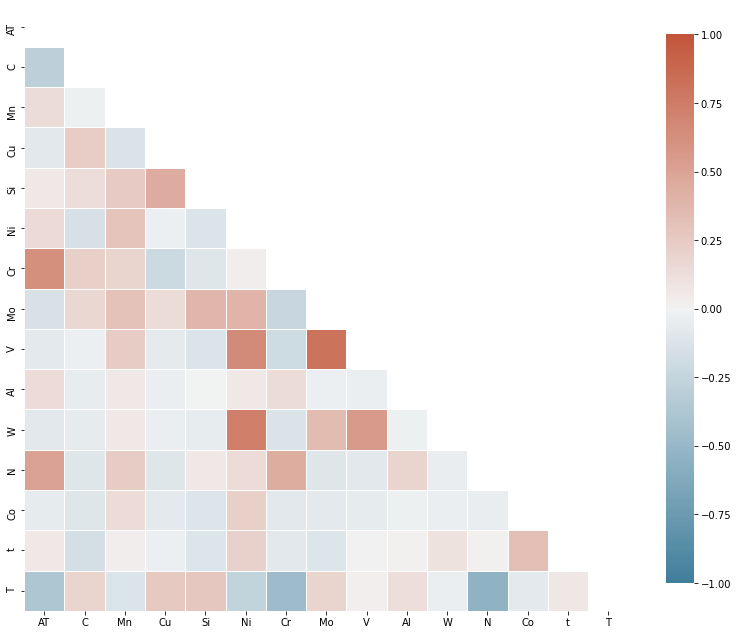

In [4]:
_ = correlation_matrix(df)

We also inspect the composition of the grades. It is not worth keeping elements that are not representative with regards to their presence across the whole dataset. It is also important to keep this alloys in mind when checking the validation data and their proper representation in training data.

In [5]:
df.groupby(df.columns[1:-2].tolist()).first()

AT  \
C    Mn   Cu   Si   Ni   Cr    Mo   V     Al    W    N    Co           
0.06 0.00 0.00 0.00 0.00 12.80 0.00 0.000 0.000 0.00 0.00 0.00   980   
0.07 0.21 0.00 0.30 0.09 12.30 0.00 0.000 0.000 0.00 0.00 0.00  1100   
0.09 0.40 0.00 0.33 0.34 17.20 0.00 0.000 0.000 0.00 0.03 0.00  1090   
                               0.06 0.000 0.010 0.00 0.03 0.00  1095   
     0.44 0.00 0.29 0.00 12.66 0.00 0.000 0.000 0.00 0.00 0.00   982   
0.10 0.00 0.00 0.00 0.00 12.40 0.00 0.000 0.000 0.00 0.00 0.00   980   
0.11 0.44 0.00 0.37 0.16 12.18 0.00 0.000 0.000 0.00 0.00 0.00   982   
                               0.02 0.000 0.000 0.00 0.00 0.00   980   
     0.49 0.00 0.10 0.48 12.80 0.00 0.000 0.000 0.00 0.00 0.45  1000   
               0.45 0.13 12.00 0.02 0.020 0.000 0.00 0.00 0.00  1000   
          0.07 0.45 0.13 12.00 0.02 0.020 0.000 0.06 0.00 0.00  1000   
     0.62 0.00 0.31 0.15 13.24 0.02 0.000 0.000 0.00 0.00 0.00   980   
0.12 0.00 0.00 0.00 0.00 12.30 0.00 0.000 0.000 0.00 0.00 0.00   980   
     0.34 0.00 0.24 1.77 11.30 0.43 0.270 0.000 1.60 0.00 0.00   950   
     0.49 0.00 0.09 0.46 12.50 0.00 0.000 0.000 0.00 0.00 0.99  1000   
0.13 0.33 0.00 0.52 0.12 12.50 0.00 0.000 0.000 0.00 0.00 0.00   980   
     0.49 0.00 0.15 0.51 12.40 0.00 0.000 0.000 0.00 0.00 8.00  1000   
     0.52 0.00 0.22 0.48 12.80 0.00 0.000 0.000 0.00 0.00 4.90  1000   
0.15 1.00 0.00 0.50 0.00 13.00 0.00 0.000 0.000 0.00 0.00 0.00   980   
0.17 0.56 0.00 0.46 0.35 20.96 0.04 0.000 0.013 0.00 0.12 0.00  1260   
               0.56 0.35 20.96 0.00 0.000 0.000 0.00 0.17 0.00  1260   
0.22 0.52 0.00 0.35 0.59 12.00 1.35 0.310 0.000 0.31 0.00 0.00  1020   
     0.54 0.00 0.00 0.64 12.46 0.99 0.290 0.000 0.00 0.00 0.00  1010   
0.24 0.27 0.00 0.37 0.32 13.32 0.06 0.000 0.000 0.00 0.00 0.00   960   
     0.46 0.00 0.42 0.26 24.85 0.00 0.000 0.000 0.00 0.00 0.00  1260   
0.25 0.29 0.00 0.37 0.13 13.40 0.00 0.000 0.000 0.00 0.00 0.00   980   
0.29 0.40 0.00 0.85 0.18 13.32 0.10 0.000 0.000 0.00 0.00 0.00  1000   
0.30 0.48 0.07 2.20 0.12 10.50 1.00 0.012 0.000 0.00 0.00 0.00  1000   
0.42 0.16 0.08 0.44 0.27 13.40 0.00 0.000 0.000 0.00 0.00 0.00  1000   
0.44 0.20 0.09 0.30 0.31 13.12 0.01 0.020 0.000 0.00 0.00 0.00  1050   
0.45 0.40 0.00 0.32 0.12 13.80 0.00 0.000 0.000 0.00 0.00 0.00   980   
0.62 0.30 0.00 0.17 0.00 16.59 0.00 0.000 0.000 0.00 0.00 0.00   870   
0.93 0.49 0.00 0.43 0.00 18.40 0.55 0.000 0.000 0.00 0.00 0.00   870   

                                                                          t  \
C    Mn   Cu   Si   Ni   Cr    Mo   V     Al    W    N    Co                  
0.06 0.00 0.00 0.00 0.00 12.80 0.00 0.000 0.000 0.00 0.00 0.00   2762.34528   
0.07 0.21 0.00 0.30 0.09 12.30 0.00 0.000 0.000 0.00 0.00 0.00   1556.28340   
0.09 0.40 0.00 0.33 0.34 17.20 0.00 0.000 0.000 0.00 0.03 0.00   5322.96660   
                               0.06 0.000 0.010 0.00 0.03 0.00   7200.00000   
     0.44 0.00 0.29 0.00 12.66 0.00 0.000 0.000 0.00 0.00 0.00   4873.15734   
0.10 0.00 0.00 0.00 0.00 12.40 0.00 0.000 0.000 0.00 0.00 0.00   6364.88234   
0.11 0.44 0.00 0.37 0.16 12.18 0.00 0.000 0.000 0.00 0.00 0.00   5538.62177   
                               0.02 0.000 0.000 0.00 0.00 0.00   4490.32955   
     0.49 0.00 0.10 0.48 12.80 0.00 0.000 0.000 0.00 0.00 0.45   9219.94129   
               0.45 0.13 12.00 0.02 0.020 0.000 0.00 0.00 0.00   3288.22508   
          0.07 0.45 0.13 12.00 0.02 0.020 0.000 0.06 0.00 0.00   3185.85580   
     0.62 0.00 0.31 0.15 13.24 0.02 0.000 0.000 0.00 0.00 0.00   2457.65699   
0.12 0.00 0.00 0.00 0.00 12.30 0.00 0.000 0.000 0.00 0.00 0.00  17156.47971   
     0.34 0.00 0.24 1.77 11.30 0.43 0.270 0.000 1.60 0.00 0.00  49502.50690   
     0.49 0.00 0.09 0.46 12.50 0.00 0.000 0.000 0.00 0.00 0.99  11308.32087   
0.13 0.33 0.00 0.52 0.12 12.50 0.00 0.000 0.000 0.00 0.00 0.00   1047.47130   
     0.49 0.00 0.15 0.51 12.40 0.00 0.000 0.000 0.00 0.00 8.00  84328.67757   
     0.52 0.00 0.22 0.48 12.80 0.00 0.000 0.

Since it is not only the training data that needs to be processed, but also the validation data sets, it makes sense to provide a function with standard raw data treatment as given by `process_df`.

In [6]:
def process_df(df, pca, pf):
    """ Apply standard data processing. """
    X_ = df.iloc[:, :-1].to_numpy()
    y_ = df.iloc[:, -1].to_numpy()
    
    X_ = pf.fit_transform(X_)
    X_ = pca.transform(X_)
    
    data = np.hstack((X_, y_.reshape(1, -1).T))
    cols = [F'c{n}' for n in range(X_.shape[1])]
    
    return pd.DataFrame(data, columns=[*cols, 'y'])

# #     df.insert(1, '(Ni+1)*(W+1)', (df['Ni'] + 1) * (df['W'] + 1))
# #     df.insert(1, 'Cr*AT', df['Cr'] * df['AT'])
# #     df.insert(1, 'Cr*(1+N)*AT', df['Cr'] * (1 + df['N']) * df['AT'])
#     df.insert(1, 'Mo+V', df['Mo'] + df['V'])
# #     df.insert(1, 'Cr*AT', df['Cr'] * df['AT'])
#     df.insert(1, 'Cr*AT/(1+N)', df['Cr'] * df['AT'] / (1 + df['N']))
    
#     # This was considered by requires new parameter
#     # tunning to beat all benchmark values.
#     # df.insert(1, 'Ni+W', df['Ni'] + df['W'])
        
#     return df.drop([
#         # Deleterious to performance:
#         'Cu', 
#         'Al',
# #         'W',
#         'Ni',
#         # Used in new features:
#         'Mo', 
#         'V',
#         'Cr',
#         'AT',
#         'N'
#     ], axis=1)

In [20]:
pf = PolynomialFeatures(interaction_only=True,
                        include_bias=False)
pca = PCA(n_components=30, svd_solver='full')
X_ = df.iloc[:, :-1].to_numpy()
X_ = pf.fit_transform(X_)
pca.fit(X_)

PCA(n_components=30, svd_solver='full')

Before performing training/testing split, we pre-process data and select columns for predictors and target. Here a fixed random state is applied for data splitting for ensuring reproducibility. The correlation matrix of new features is displayed next. As one may verify, except for the correlation with target `T` most parameters as weakly coupled now.

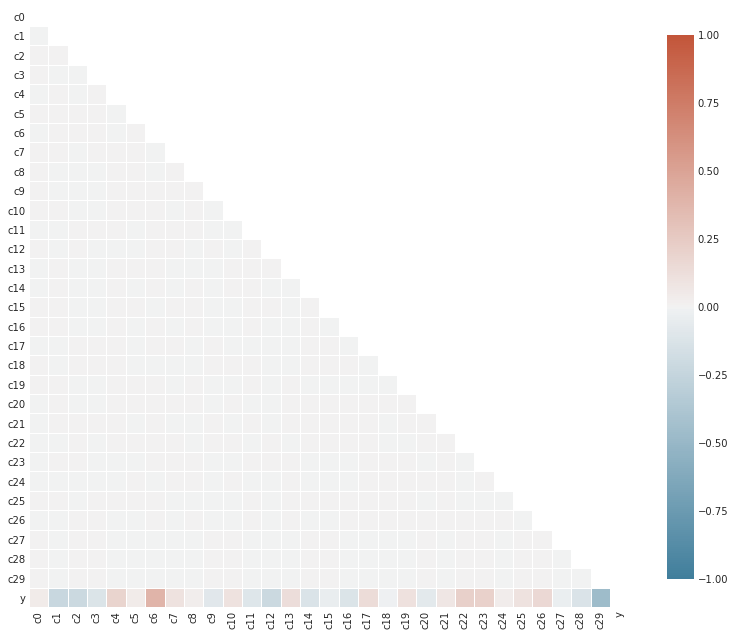

In [21]:
tmp = process_df(df, pca, pf)

names = tmp.columns.tolist()
y_names = names.pop(-1)
X_names = names.copy()

X = tmp[X_names].to_numpy()
y = tmp[y_names].to_numpy()

X_train, X_tests, y_train, y_tests, scaler =\
    split_transform_data(X, y, test_size=0.2,
                         random_state=42,
                         use_scaler=True)

_ = correlation_matrix(tmp)

In [22]:
tmp.corr()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c21,c22,c23,c24,c25,c26,c27,c28,c29,y
c0,1.000000e+00,-5.018497e-15,5.886176e-16,1.010119e-15,-6.577042e-16,4.884427e-16,-2.217391e-15,8.146808e-16,2.597283e-15,7.574149e-16,...,-4.015252e-12,-3.804035e-10,-5.845236e-10,-2.384342e-10,1.107190e-10,-3.359275e-10,3.928255e-09,4.015153e-09,6.988778e-09,0.041698
c1,-5.018497e-15,1.000000e+00,7.094132e-16,-8.781575e-16,2.807646e-17,5.461447e-17,1.780145e-15,3.473062e-16,-1.039454e-16,-8.631924e-16,...,1.961478e-14,-4.384327e-14,1.413850e-15,-4.113158e-14,1.670442e-13,-1.960641e-12,-1.776662e-11,-9.021121e-11,-1.044055e-10,-0.231667
c2,5.886176e-16,7.094132e-16,1.000000e+00,-4.448826e-15,-1.040235e-15,-5.540279e-17,8.622404e-16,-5.057486e-16,-5.620412e-16,-1.143877e-15,...,4.603005e-15,4.805463e-15,1.554278e-14,-9.984746e-15,-7.269889e-15,5.827677e-13,2.483786e-11,1.162032e-10,1.415353e-10,-0.217288
c3,1.010119e-15,-8.781575e-16,-4.448826e-15,1.000000e+00,4.820022e-16,1.846098e-16,1.517068e-16,2.630552e-16,-6.190647e-16,-8.034803e-16,...,2.518951e-15,-6.055308e-15,-4.930675e-15,-2.996508e-14,4.779222e-14,1.722066e-13,1.696864e-11,7.637587e-11,9.645083e-11,-0.123536
c4,-6.577042e-16,2.807646e-17,-1.040235e-15,4.820022e-16,1.000000e+00,-7.331678e-16,-3.971239e-16,-4.098336e-17,6.838594e-16,4.528253e-16,...,6.700827e-15,6.662989e-15,-8.326776e-15,-1.715672e-14,5.013725e-16,-2.194570e-12,-6.367589e-12,-3.043410e-11,-4.480590e-11,0.189649
c5,4.884427e-16,5.461447e-17,-5.540279e-17,1.846098e-16,-7.331678e-16,1.000000e+00,3.408361e-16,7.267875e-17,1.494061e-16,3.630293e-16,...,-2.809019e-16,1.102438e-14,-3.134702e-14,1.663331e-16,1.194088e-14,-1.682218e-12,-6.221050e-12,-3.018937e-11,-4.415357e-11,0.043138
c6,-2.217391e-15,1.780145e-15,8.622404e-16,1.517068e-16,-3.971239e-16,3.408361e-16,1.000000e+00,-3.789839e-16,-7.179957e-16,1.975328e-16,...,3.694861e-15,5.707494e-15,6.962287e-16,-1.607091e-14,3.009065e-14,5.059605e-13,-9.120393e-13,-2.427239e-12,-3.884491e-12,0.397031
c7,8.146808e-16,3.473062e-16,-5.057486e-16,2.630552e-16,-4.098336e-17,7.267875e-17,-3.789839e-16,1.000000e+00,2.053801e-16,1.566289e-15,...,-2.391975e-15,7.020994e-16,3.517249e-15,1.581886e-15,-3.382226e-15,-1.420061e-13,-7.013739e-12,-3.377418e-11,-4.009323e-11,0.100350
c8,2.597283e-15,-1.039454e-16,-5.620412e-16,-6.190647e-16,6.838594e-16,1.494061e-16,-7.179957e-16,2.053801e-16,1.000000e+00,9.897170e-17,...,-3.740749e-15,-3.083672e-15,3.396501e-15,8.430274e-16,-2.678580e-15,1.028411e-13,-8.965275e-12,-4.246235e-11,-5.286075e-11,0.024034
c9,7.574149e-16,-8.631924e-16,-1.143877e-15,-8.034803e-16,4.528253e-16,3.630293e-16,1.975328e-16,1.566289e-15,9.897170e-17,1.000000e+00,...,8.486553e-16,3.136191e-15,-5.417575e-15,-1.032376e-14,-9.837048e-15,-4.199006e-14,1.144935e-11,5.447467e-11,6.815753e-11,-0.089508


Because of constraints regarding the validation sets there is not much clean-up to be done in what follows, but for information the boxplot of predictors is displayed next.

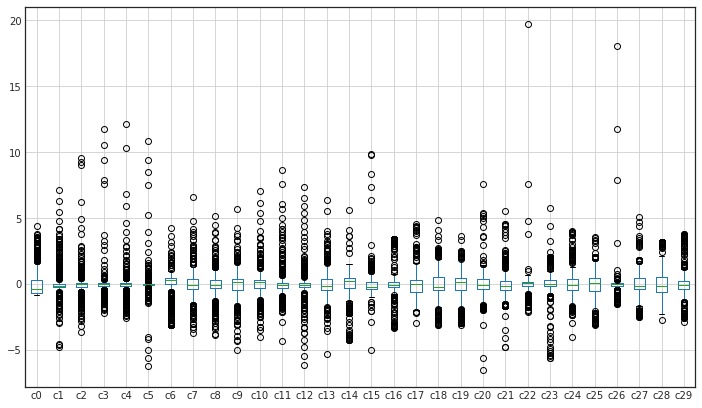

In [23]:
_ = pd.DataFrame(X_train, columns=X_names)\
    .boxplot(column=X_names, figsize=(12,7), grid=':')

## Prepare for validation

Currently we are using only XGBoost, but there might be a need/interest to include other models later. We provide early a function for treating and displaying all validation sets and associated predictions. This function expects the benchmark table as an argument for adding this work's data.

In [24]:
def validate_set(model, df, bm, num):
    """ Perform validation of dataset with model. """  
    X_valid = df[X_names].to_numpy()
    y_valid = df[y_names].to_numpy()

    if scaler is not None:
        X_valid = scaler.apply_to(X_valid)
        
    _, rmse = regression_plot(model,
                              None, X_valid,
                              None, y_valid,
                              lims_corr=(None, None),
                              x_lim_hist=(None, None))
    
    bm.loc[len(bm.index)] = [num, rmse, 'This work']

Validation sets are also loaded and compositions displayed. Notice that `Al` is never required and `Cu`, `W`, `N`, and `Co` are used in a single set. From that is is clear that `Al` can be eliminated. For the case of `Cu` and `W`, these elements were removed for disturbing the predictions as a whole, favoring only reference alloys. 

In [25]:
df1 = pd.read_csv('datasets/pe-upper-validation-1.csv')
df2 = pd.read_csv('datasets/pe-upper-validation-2.csv')
df3 = pd.read_csv('datasets/pe-upper-validation-3.csv')
df4 = pd.read_csv('datasets/pe-upper-validation-4.csv')
df5 = pd.read_csv('datasets/pe-upper-validation-5.csv')

pd.concat([
    df1.groupby(df1.columns[1:-2].tolist()).first(),
    df2.groupby(df2.columns[1:-2].tolist()).first(),
    df3.groupby(df3.columns[1:-2].tolist()).first(),
    df4.groupby(df4.columns[1:-2].tolist()).first(),
    df5.groupby(df5.columns[1:-2].tolist()).first()
])

,,,,,,,,,,,,AT,t,T
C,Mn,Cu,Si,Ni,Cr,Mo,V,Al,W,N,Co,,,
0.08,0.43,0.00,0.22,0.35,11.28,0.05,0.00,0,0.0,0.000,0.00,900,6819.02210,704.781730
0.12,0.79,0.00,0.74,0.25,12.82,0.05,0.00,0,0.0,0.037,0.00,980,3399.96689,722.293461
0.13,0.50,0.00,0.45,0.52,13.20,0.00,0.00,0,0.0,0.000,1.87,1000,16962.12447,652.540950
0.44,0.20,0.09,0.30,0.31,13.12,0.01,0.02,0,0.0,0.000,0.00,980,830.24284,703.346480
0.12,0.34,0.00,0.24,1.77,11.30,0.43,0.27,0,1.6,0.000,0.00,1070,25463.41751,675.830000


Same processing as for training data is applied to validation sets.

In [26]:
df1 = process_df(df1, pca, pf)
df2 = process_df(df2, pca, pf)
df3 = process_df(df3, pca, pf)
df4 = process_df(df4, pca, pf)
df5 = process_df(df5, pca, pf)

## XGBoost modeling

XGBoost is a well-known high performance regressor and since it was not used in reference paper it is choosen here. The model training is divided in two steps: first a cross-validation is employed for determining the optimal number of regressors (trees) to be added, then the model to be used later is trained. In `param` dictionary other hyper-parameters that were manully tunned are present. Notice that optimal learning rate was found to be the default one, as usual with XGBoost.

In [27]:
X_names

['c0',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'c10',
 'c11',
 'c12',
 'c13',
 'c14',
 'c15',
 'c16',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c22',
 'c23',
 'c24',
 'c25',
 'c26',
 'c27',
 'c28',
 'c29']

In [28]:
# monotone_constraints = "(0,0,0,0,0,0,0,0,0)"
monotone_constraints = None

In [29]:
param = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 4,
    'num_parallel_tree': 2,
    'monotone_constraints': monotone_constraints
}

cv_results = xgboost.cv(
    dtrain=xgboost.DMatrix(
        data=X_train, label=y_train,
        feature_names=X_names), 
    params=param,
    nfold=5,
    num_boost_round=2000,
    early_stopping_rounds=10,
    metrics='rmse',
    as_pandas=True,
    seed=42
)
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
397,0.695219,0.017665,16.145776,6.369513
398,0.691345,0.018028,16.144654,6.371120
399,0.688866,0.019567,16.144535,6.370746
400,0.687415,0.019526,16.143657,6.371012
401,0.684280,0.020305,16.143057,6.371267


The number of estimators is determined and the actual model is trained. We compare the predictions against expected value and also display the histogram of errors in both test and training sets.

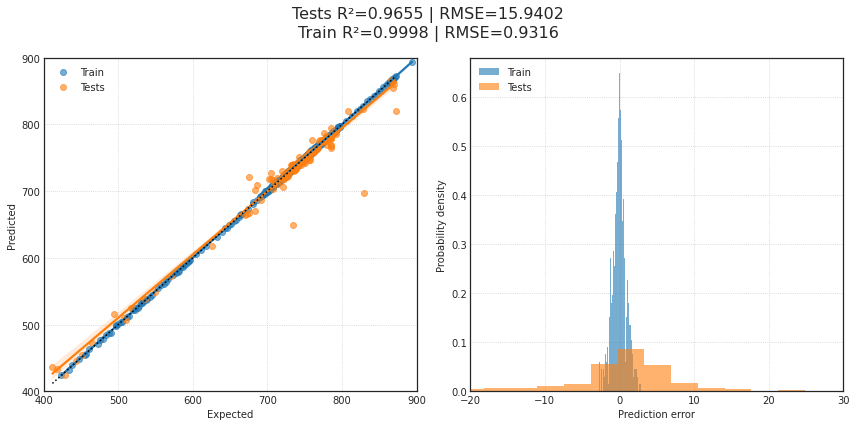

In [30]:
n_estimators = len(cv_results.index)
xgb = xgboost.XGBRegressor(n_estimators=n_estimators, **param)
xgb.fit(X_train, y_train)

_ = regression_plot(xgb, X_train, X_tests, y_train, y_tests,
                    lims_corr=(400, 900), x_lim_hist=(-20, +30))

As a final step the model is confronted to unseen data (validation). The benchmark table is loaded and fed for each dataset.

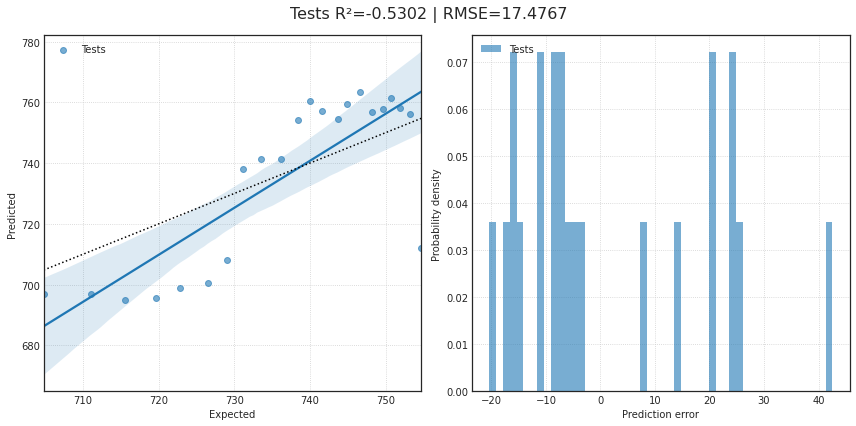

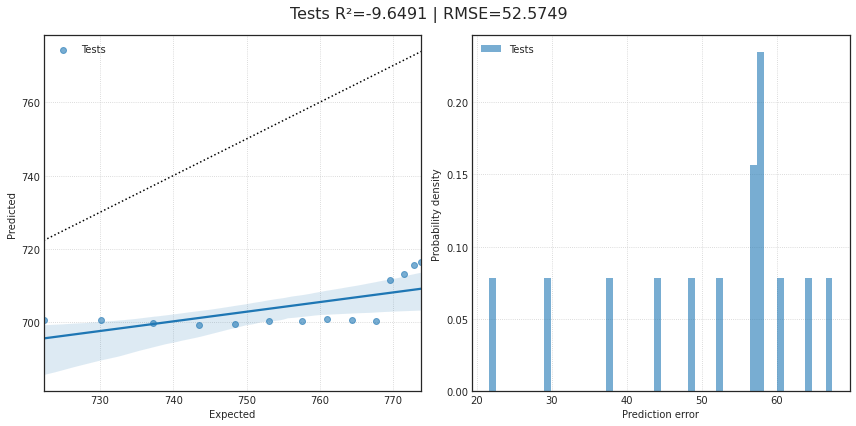

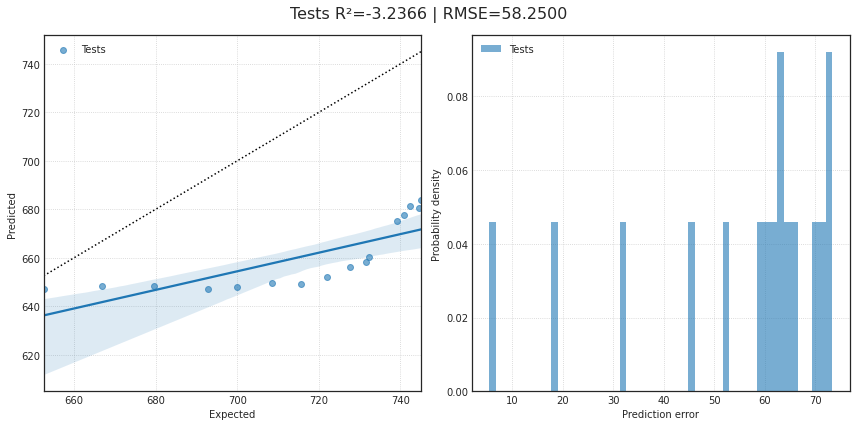

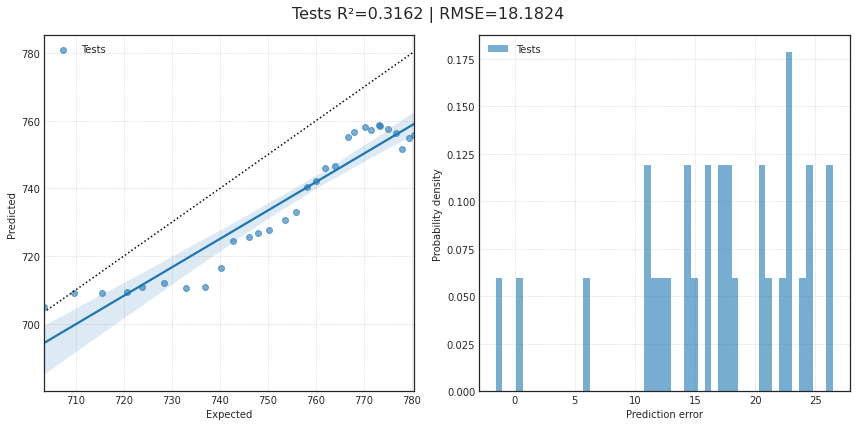

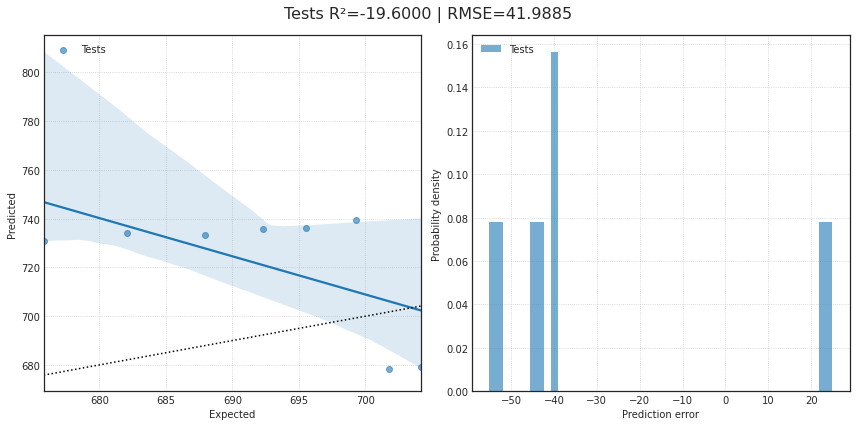

In [31]:
bm = pd.read_csv('datasets/pe-upper-reference.csv')

validate_set(xgb, df1, bm, 1)
validate_set(xgb, df2, bm, 2)
validate_set(xgb, df3, bm, 3)
validate_set(xgb, df4, bm, 4)
validate_set(xgb, df5, bm, 5)

## Conclusions

The following histogram shows that even without much parameter tunning XGBoost is alone capable of outperforming the reference paper. The most difficult step was not actually related to the model, but to the preprocessing of data and feature engineering.

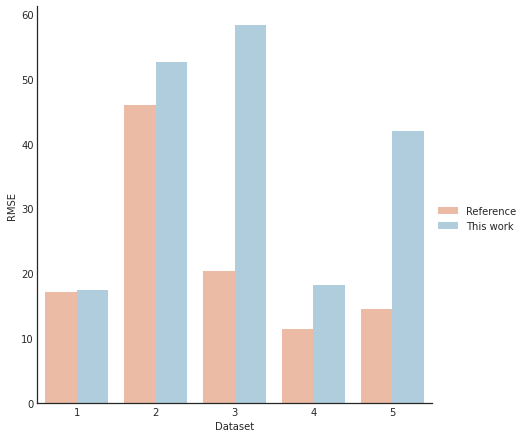

In [32]:
plot_benchmark(bm)